# Analytics
The notebook will be used to clean, transform, analyze and visualize the data

# Libraries

In [2]:
from pandasql import sqldf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm

# Functions

In [3]:
def fDistNumCols(df, columns, ncols, axis):

    '''
    Plot distributions
    
    df - data frame
    columns - list of columns to plot
    ncols - number of columns
    axis - which axis will be used for plotting
    '''
    
    # Number of charts
    n = len(columns)

    # Number of columns
    ncols = 2

    # Number of rows
    nrows = math.ceil(n / ncols)

    # Define subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 5 * nrows))

    # Loop through all subplots
    for i, j in zip(columns, axes.flat):
        if axis == 'x':
            sns.histplot(df, x=i,  ax=j)
        else:
            sns.histplot(df, y=i,  ax=j)

    # plt.tight_layout()

In [4]:
def fScatter(df, columns_init, target, ncols, figsizew, figsizeh):

    '''
    Plot relations between the features and the target
    
    df - data frame
    columns_init - list of columns to plot
    ncols - number of columns
    target - the target column which scatterplot will be plotted against
    figsizew - width of the plot
    figsizeh - height of the plot
    '''
    
    # Duplicate the array to plot 2 charts
    columns = np.array(columns_init).repeat(2)
    
    # Number of charts
    n = len(columns)

    # Number of rows
    nrows = math.ceil(n / ncols)

    # Define subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsizew, figsizeh * nrows))
    
    # 
    odd = True
    
    # Loop through all subplots
    for i, j in zip(columns, axes.flat):
        if odd:
            sns.scatterplot(data=df, x=i, y=target,  ax=j).set(title='Total')
            odd = False
        else:
            sns.scatterplot(data=dfFootball.groupby(i)[[target]].mean().reset_index(), x=i, y=target,  ax=j).set(title='Average')
            odd = True

# Initialization

In [5]:
# Display all columns
pd.set_option('display.max_columns', None)

# Load from files

In [6]:
dfLeaguesCSV = pd.read_csv('raw_data/leagues.csv')
dfTeamsCSV = pd.read_csv('raw_data/teams.csv')

# Initialize empty data frames
dfPlayersCSV = pd.DataFrame()
dfPlayerStatsCSV = pd.DataFrame()

# Load all players files
for name in glob.glob('raw_data/players_*.csv'):
    dfPlayersTemp = pd.read_csv(name)
    dfPlayersCSV = pd.concat([dfPlayersCSV, dfPlayersTemp])
    
# Load all player stats files
for name in glob.glob('raw_data/player_stats_*.csv'):
    dfPlayerStatsTemp = pd.read_csv(name)
    dfPlayerStatsCSV = pd.concat([dfPlayerStatsCSV, dfPlayerStatsTemp])

## Columns description

# Clean and transform

## Join all data frames
There are several data frames. To perform analysis and build models we need to have just one. Hence we need to combine them.

In [7]:
# Merge players and player stats data sets
dfFootballCSV = dfPlayersCSV.merge(dfPlayerStatsCSV, left_on=['player_id','league_id','season_id'],\
                             right_on=['player_id','league_id','season_id'], suffixes=('', '_new'))

# Merge the result and teams data sets
dfFootballCSV = dfFootballCSV.merge(dfTeamsCSV, left_on=['team_id','league_id','season_id'],\
                             right_on=['team_id','league_id','season_id'], suffixes=('', '_new'))

# Merge the result and leagues data sets
dfFootballCSV = dfFootballCSV.merge(dfLeaguesCSV, left_on='league_id',\
                             right_on='league_id', suffixes=('', '_new'))

In [8]:
dfFootballCSV.shape

(65880, 79)

## Initial analysis

Sample. Just to check columns and data inside.

In [8]:
# You can change the index in the .iloc to see more columns
dfFootballCSV.iloc[:,0:].sample(5)

,player_id,player_name,player_firstname,player_lastname,player_age,player_birth_date,player_birth_place,player_birth_country,player_nationality,player_height,player_weight,player_injured,player_photo,league_id,season_id,team_id,team_name,team_logo,league_name,league_country,league_logo,league_flag,league_season,games_appearences,games_lineups,games_minutes,games_number,games_position,games_rating,games_captain,substitutes_in,substitutes_out,substitutes_bench,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_yellowred,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,team_name_new,team_code,team_country,team_founded,team_national,team_logo_new,venue_id,venue_name,venue_address,venue_city,venue_capacity,venue_surface,venue_image,league_name_new,league_type,league_logo_new,country_name,country_code,country_flag
36839,246,L. de Jong,Luuk,de Jong,33.0,1990-08-27,Aigle,Switzerland,Netherlands,188 cm,86 kg,False,https://media-2.api-sports.io/football/players...,88,2017,197,PSV Eindhoven,https://media-2.api-sports.io/football/teams/1...,Eredivisie,Netherlands,https://media-3.api-sports.io/football/leagues...,https://media-2.api-sports.io/flags/nl.svg,2017,28.0,22.0,2076.0,NaN,Attacker,7.403571,False,6.0,5.0,8.0,96.0,50.0,12.0,NaN,5.0,NaN,455.0,48.0,66.0,1.0,1.0,6.0,419.0,223.0,19.0,9.0,NaN,36.0,18.0,1.0,0.0,0.0,3.0,NaN,0.0,0.0,NaN,PSV Eindhoven,PSV,Netherlands,1913.0,False,https://media-1.api-sports.io/football/teams/1...,1143,Philips Stadion,Frederiklaan 10,Eindhoven,36150,grass,https://media-2.api-sports.io/football/venues/...,Eredivisie,League,https://media-2.api-sports.io/football/leagues...,Netherlands,NL,https://media-3.api-sports.io/flags/nl.svg
1256,1910,M. Lopez,Maxime,Lopez,26.0,1997-12-04,Marseille,France,France,167 cm,58 kg,False,https://media-2.api-sports.io/football/players...,61,2020,81,Marseille,https://media-3.api-sports.io/football/teams/8...,Ligue 1,France,https://media-3.api-sports.io/football/leagues...,https://media-2.api-sports.io/flags/fr.svg,2020,4.0,2.0,134.0,NaN,Midfielder,6.650000,False,2.0,2.0,4.0,NaN,NaN,0.0,0.0,NaN,NaN,56.0,1.0,11.0,1.0,NaN,2.0,11.0,3.0,1.0,1.0,NaN,1.0,4.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,Marseille,MAR,France,1899.0,False,https://media-1.api-sports.io/football/teams/8...,12678,Stade Orange Vélodrome,"3, boulevard Michelet",Marseille,67394,grass,https://media-3.api-sports.io/football/venues/...,Ligue 1,League,https://media-2.api-sports.io/football/leagues...,France,FR,https://media-2.api-sports.io/flags/fr.svg
35946,37789,P. Mlapa,Peniel Kokou,Mlapa,32.0,1991-02-20,Lomé,Togo,Togo,193 cm,93 kg,False,https://media-3.api-sports.io/football/players...,88,2018,204,VVV Venlo,https://media-2.api-sports.io/football/teams/2...,Eredivisie,Netherlands,https://media-1.api-sports.io/football/leagues...,https://media-3.api-sports.io/flags/nl.svg,2018,30.0,29.0,2475.0,NaN,Attacker,7.172413,False,1.0,10.0,3.0,86.0,32.0,15.0,NaN,2.0,NaN,329.0,20.0,58.0,7.0,5.0,3.0,397.0,185.0,24.0,10.0,NaN,28.0,38.0,4.0,0.0,0.0,2.0,1.0,2.0,0.0,NaN,VVV Venlo,VEN,Netherlands,1954.0,False,https://media-3.api-sports.io/football/teams/2...,1158,Covebo Stadion - De Koel -,Kaldenkerkerweg 182,Venlo,8000,artificial turf,https://media-1.api-sports.io/football/venues/...,Eredivisie,League,https://media-2.api-sports.io/football/leagues...,Netherlands,NL,https://media-3.api-sports.io/flags/nl.svg
32064,91319,Marco Borriello,Marco,Borriello,37.0,1982-06-18,Napoli,Italy,Italy,180 cm,73 kg,False,https://media-2.api-sports.io/football/players...,135,2015,499,Atalanta,https://media-2.api-sports.io/football/teams/4...,Serie A,Italy,https://media-3.api-sports.io/football/leagues...,https://media-2.api-sports.io/flags/it.svg,2015,15.0,8.0,850.0,NaN,Attacker,6.800000,False,7.0,2.0,9

Shape. To see number of columns and rows.

In [9]:
dfFootballCSV.shape

(65880, 79)

Statistical info. To check min/max, unique, top values.

In [10]:
dfFootballCSV.describe(include='all').style.set_sticky(axis="index")

,player_id,player_name,player_firstname,player_lastname,player_age,player_birth_date,player_birth_place,player_birth_country,player_nationality,player_height,player_weight,player_injured,player_photo,league_id,season_id,team_id,team_name,team_logo,league_name,league_country,league_logo,league_flag,league_season,games_appearences,games_lineups,games_minutes,games_number,games_position,games_rating,games_captain,substitutes_in,substitutes_out,substitutes_bench,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_yellowred,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,team_name_new,team_code,team_country,team_founded,team_national,team_logo_new,venue_id,venue_name,venue_address,venue_city,venue_capacity,venue_surface,venue_image,league_name_new,league_type,league_logo_new,country_name,country_code,country_flag
count,65880.000000,65878,65878,65878,65867.000000,65867,61114,65878,65878,63635,60662,65880,65880,65880.000000,65880.000000,65880.000000,65880,65880,65880,65880,65880,65880,65880.000000,65503.000000,65503.000000,65503.000000,0.000000,65877,31295.000000,65880,65503.000000,65503.000000,65503.000000,29383.000000,28248.000000,65503.000000,17152.000000,14238.000000,2410.000000,31677.000000,29478.000000,31626.000000,22907.000000,22529.000000,29624.000000,30004.000000,29721.000000,29827.000000,29360.000000,0.000000,30184.000000,30204.000000,65503.000000,65503.000000,65503.000000,2488.000000,3048.000000,34023.000000,34023.000000,3132.000000,65880,64627,65880,65014.000000,65880,65880,65880.000000,65880,64950,65813,65880.000000,65880,65880,65880,65880,65880,65880,65880,65880
unique,nan,19764,9423,17398,nan,7720,5808,171,171,52,60,1,36247,nan,nan,nan,309,927,9,10,30,30,nan,nan,nan,nan,nan,4,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,309,244,11,nan,1,751,nan,290,284,262,nan,2,702,9,1,10,10,10,10
top,nan,Paulinho,Daniel,Traoré,nan,1993-03-05,Amsterdam,France,Spain,180 cm,75 kg,False,https://media-2.api-sports.io/football/players/19034.png,nan,nan,nan,Genoa,https://media-1.api-sports.io/football/teams/495.png,Premier League,Italy,https://media-3.api-sports.io/football/leagues/135.png,https://media-1.api-sports.io/flags/it.svg,nan,nan,nan,nan,nan,Midfielder,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Genoa,GEN,Italy,nan,False,https://media-2.api-sports.io/football/teams/494.png,nan,Stadio Comunale Luigi Ferraris,Stadionplein 1,London,nan,grass,https://media-1.api-sports.io/football/venues/905.png,Premier League,League,https://media-1.api-sports.io/football/leagues/135.png,Italy,IT,https://media-1.api-sports.io/flags/it.svg
freq,nan,37,323,99,nan,59,709,6799,5256,4852,4225,65880,10,nan,nan,nan,445,166,12583,8134,2747,2739,nan,nan,nan,nan,nan,22365,nan,65880,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,445,1463,8134,nan,65880,293,nan,850,952,2030,nan,63144,362,12583,65880,8134,8134,8134,8134
mean,51745.975137,nan,nan,nan,30.285545,nan,nan,nan,nan,nan,nan,nan,nan,127.894520,2016.676988,778.168139,nan,nan,nan,nan,nan,nan,2016.676988,13.582492,10.582706,949.958658,nan,nan,6.779501,nan,2.999786,2.997466,7.788895,15.251676,6.054376,1.299284,3.177705,2.581894,47.830290,461.572087,12.351075,53.948650,19.598114,3.902526,16.691770,129.025497,65.058040,20.752975,12.015702,nan,16.039094,16.918388,2.005984,0.057646,0.057158,1.296624,1.231627,0.147665,0.040649,0.446041,nan,nan,nan,1922.799182,nan,nan,3229.381922,nan,nan,nan,32831.787993,nan,nan,nan,nan,nan,nan,nan,nan
std,62967.831985,nan,nan,nan,5.018757,nan,nan,nan,nan,nan,nan,nan,nan,76.751904,2.903

Column types and null values.

In [11]:
dfFootballCSV.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65880 entries, 0 to 65879
Data columns (total 79 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   player_id              65880 non-null  int64  
 1   player_name            65878 non-null  object 
 2   player_firstname       65878 non-null  object 
 3   player_lastname        65878 non-null  object 
 4   player_age             65867 non-null  float64
 5   player_birth_date      65867 non-null  object 
 6   player_birth_place     61114 non-null  object 
 7   player_birth_country   65878 non-null  object 
 8   player_nationality     65878 non-null  object 
 9   player_height          63635 non-null  object 
 10  player_weight          60662 non-null  object 
 11  player_injured         65880 non-null  bool   
 12  player_photo           65880 non-null  object 
 13  league_id              65880 non-null  int64  
 14  season_id              65880 non-null  int64  
 15  te

## Drop columns

In [12]:
# With all NA records
dfFootballCSV = dfFootballCSV.drop(dfFootballCSV.columns[dfFootballCSV.isna().all()].to_list(), axis=1)

# With all False records
dfFootballCSV = dfFootballCSV.drop(dfFootballCSV.columns[(dfFootballCSV == False).all()].to_list(), axis=1)

# All values the same
dfFootballCSV = dfFootballCSV.drop(dfFootballCSV.columns[dfFootballCSV.nunique() == 1].to_list(), axis=1)

## Replace values

### Find '\n    ' and replace with NaN

In [13]:
# Find coordinates of the cells
r, c = np.where(dfFootballCSV == '\n    ')

# Loop through each column and replace
for i in dfFootballCSV.columns[list(set(c))].to_list():
    dfFootballCSV.loc[dfFootballCSV[i] == '\n    ', i] = np.nan

### Weight and height

In [14]:
# Remove cm and \n from player_height
dfFootballCSV.player_height = dfFootballCSV.player_height.str.replace(' cm', '')

# Remove kg from player_weight
dfFootballCSV.player_weight = dfFootballCSV.player_weight.str.replace(' kg', '')

# Temporary fill NA with 0 to convert the columns to int
dfFootballCSV.player_height = dfFootballCSV.player_height.fillna(0)
dfFootballCSV.player_weight = dfFootballCSV.player_weight.fillna(0)

# Convert to int
dfFootballCSV.player_height = dfFootballCSV.player_height.astype('int32')
dfFootballCSV.player_weight = dfFootballCSV.player_weight.astype('int32')

### Escape character single quote

In [15]:
dfFootballCSV.venue_city = dfFootballCSV.venue_city.str.replace('&apos;', "'")

## Null values

Get all columns containing null values

Ignore *venue_address, team_code, games_rating*, they will be removed later

In [16]:
dfFootballCSV.columns[dfFootballCSV.isna().any()].to_list()

['player_name',
 'player_firstname',
 'player_lastname',
 'player_age',
 'player_birth_date',
 'player_birth_place',
 'player_birth_country',
 'player_nationality',
 'games_appearences',
 'games_lineups',
 'games_minutes',
 'games_position',
 'games_rating',
 'substitutes_in',
 'substitutes_out',
 'substitutes_bench',
 'shots_total',
 'shots_on',
 'goals_total',
 'goals_conceded',
 'goals_assists',
 'goals_saves',
 'passes_total',
 'passes_key',
 'passes_accuracy',
 'tackles_total',
 'tackles_blocks',
 'tackles_interceptions',
 'duels_total',
 'duels_won',
 'dribbles_attempts',
 'dribbles_success',
 'fouls_drawn',
 'fouls_committed',
 'cards_yellow',
 'cards_yellowred',
 'cards_red',
 'penalty_won',
 'penalty_commited',
 'penalty_scored',
 'penalty_missed',
 'penalty_saved',
 'team_code',
 'team_founded',
 'venue_address',
 'venue_city']

Fix

In [17]:
# Drop where no player name
dfFootballCSV = dfFootballCSV[~dfFootballCSV['player_name'].isna()]

# Drop where no birthdate/age
dfFootballCSV = dfFootballCSV[~dfFootballCSV['player_age'].isna()]

# Fill numneric columns with 0
dfFootballCSV[['games_appearences','games_lineups','games_minutes','substitutes_in','substitutes_out',\
    'substitutes_bench','shots_total','shots_on','goals_total','goals_conceded','goals_assists','goals_saves','passes_total',\
    'passes_key','passes_accuracy','tackles_total','tackles_blocks','tackles_interceptions','duels_total','duels_won',\
    'dribbles_attempts','dribbles_success','fouls_drawn','fouls_committed','cards_yellow','cards_yellowred','cards_red',\
    'penalty_won','penalty_commited','penalty_scored','penalty_missed','penalty_saved']]\
= dfFootballCSV[['games_appearences','games_lineups','games_minutes','substitutes_in','substitutes_out',\
    'substitutes_bench','shots_total','shots_on','goals_total','goals_conceded','goals_assists','goals_saves','passes_total',\
    'passes_key','passes_accuracy','tackles_total','tackles_blocks','tackles_interceptions','duels_total','duels_won',\
    'dribbles_attempts','dribbles_success','fouls_drawn','fouls_committed','cards_yellow','cards_yellowred','cards_red',\
    'penalty_won','penalty_commited','penalty_scored','penalty_missed','penalty_saved']].fillna(0)

# Populate missing venue_city
dfFootballCSV.loc[dfFootballCSV.team_name == 'Beerschot', 'venue_city'] = 'Antwerp'
dfFootballCSV.loc[dfFootballCSV.team_name == 'Kryvbas', 'venue_city'] = 'Kryvyi Rih'

# Populate missing team_founded
dfFootballCSV.loc[dfFootballCSV.team_name == 'Tondela', 'team_founded'] = '1933'
dfFootballCSV.loc[dfFootballCSV.team_name == 'Moreirense', 'team_founded'] = '1938'
dfFootballCSV.loc[dfFootballCSV.team_name == 'U. Madeira', 'team_founded'] = '1913'
dfFootballCSV.loc[dfFootballCSV.team_name == 'Rukh Vynnyky', 'team_founded'] = '2003'
dfFootballCSV.loc[dfFootballCSV.team_name == 'Kolos Kovalivka', 'team_founded'] = '2012'
dfFootballCSV.loc[dfFootballCSV.team_name == 'Fatih Karagümrük', 'team_founded'] = '1926'

# Populate missing games_position
dfFootballCSV.loc[dfFootballCSV.player_id == 70525, 'games_position'] = 'Midfielder'

# Populate missing player_birth_place with player_birth_country
dfFootballCSV.loc[dfFootballCSV.player_birth_place.isna(), 'player_birth_place'] = dfFootballCSV[dfFootballCSV.player_birth_place.isna()]\
    .apply(lambda x: x.player_birth_country, axis=1)

# Populate missing player_height and player_weight

# Calculate average height by nationality
dfTempAvgHeight = dfFootballCSV[dfFootballCSV.player_height > 0].groupby(['player_nationality','games_position'])[['player_height']].mean().reset_index()
dfTempAvgWeight = dfFootballCSV[dfFootballCSV.player_weight > 0].groupby(['player_nationality','player_age','games_position'])[['player_weight']].mean().reset_index()

# Round values
dfTempAvgHeight.player_height = round(dfTempAvgHeight.player_height)
dfTempAvgWeight.player_weight = round(dfTempAvgWeight.player_weight)

# Merge to the main data frame
dfFootballCSV = dfFootballCSV.merge(dfTempAvgHeight, how='left', on=['player_nationality','games_position'], suffixes=('', '_new'))
dfFootballCSV = dfFootballCSV.merge(dfTempAvgWeight, how='left', on=['player_nationality','player_age','games_position'], suffixes=('', '_new'))

# Fillna where no matches found
dfFootballCSV.player_height_new = dfFootballCSV.player_height_new.fillna(0)
dfFootballCSV.player_weight_new = dfFootballCSV.player_weight_new.fillna(0)

# Replace 0 with average by nationality
dfFootballCSV.loc[dfFootballCSV.player_height == 0, 'player_height'] = dfFootballCSV[dfFootballCSV.player_height == 0].player_height_new
dfFootballCSV.loc[dfFootballCSV.player_weight == 0, 'player_weight'] = dfFootballCSV[dfFootballCSV.player_weight == 0].player_weight_new

# Replace with total average where average by nationality can't be found
dfFootballCSV.loc[dfFootballCSV.player_height == 0, 'player_height'] = round(dfFootballCSV.player_height.mean())
dfFootballCSV.loc[dfFootballCSV.player_weight == 0, 'player_weight'] = round(dfFootballCSV.player_weight.mean())

## Drop "_new" columns

In [18]:
# Get all columns which contain _new in the name amd drop them
dfFootballCSV = dfFootballCSV.drop(list(filter(lambda x: '_new' in x, dfFootballCSV.columns)), axis=1)

## Drop duplicates

Theoretically we should get unique records for *player_id,team_id,league_id,season_id*. However, duplicated records are cauased by several tournaments, it is expected.

In [19]:
# Group by columns combination of which should be unique
dfTempGroup = dfFootballCSV.groupby(['player_id','team_id','league_id','season_id'])[['player_name']].count().reset_index()

# Get duplicates
dfTempGroup[dfTempGroup.player_name > 1]

,player_id,team_id,league_id,season_id,player_name
123,17,165,78,2018,2
305,42,242,94,2021,2
531,74,504,135,2019,2
1894,256,529,140,2021,2
1904,257,497,135,2012,2
...,...,...,...,...,...
64051,275542,3623,333,2020,2
64090,277249,6501,333,2021,2
64797,306196,6501,333,2021,2
64803,306354,3628,333,2021,2


Get records where all columns are duplicates

In [20]:
dfFootballCSV[dfFootballCSV.duplicated()]

,player_id,player_name,player_firstname,player_lastname,player_age,player_birth_date,player_birth_place,player_birth_country,player_nationality,player_height,player_weight,player_photo,league_id,season_id,team_id,team_name,team_logo,league_name,league_country,league_logo,league_flag,league_season,games_appearences,games_lineups,games_minutes,games_position,games_rating,substitutes_in,substitutes_out,substitutes_bench,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,fouls_drawn,fouls_committed,cards_yellow,cards_yellowred,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,team_code,team_country,team_founded,venue_id,venue_name,venue_address,venue_city,venue_capacity,venue_surface,venue_image,country_name,country_code,country_flag
45554,41264,Zainadine Júnior,Zainadine Abdula Mulungo,Chavango Júnior,35.0,1988-06-24,Maputo,Mozambique,Mozambique,178,70,https://media-2.api-sports.io/football/players...,94,2015,225,Nacional,https://media-3.api-sports.io/football/teams/2...,Primeira Liga,Portugal,https://media-2.api-sports.io/football/leagues...,https://media-3.api-sports.io/flags/pt.svg,2015,20.0,20.0,1766.0,Defender,7.0375,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,191.0,2.0,50.0,3.0,4.0,21.0,55.0,35.0,5.0,4.0,9.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NAC,Portugal,1910.0,1281,Estádio da Madeira,"Rua do Esmeraldo, nº 46",Ilha da Madeira,5200,grass,https://media-2.api-sports.io/football/venues/...,Portugal,PT,https://media-1.api-sports.io/flags/pt.svg
45555,41264,Zainadine Júnior,Zainadine Abdula Mulungo,Chavango Júnior,35.0,1988-06-24,Maputo,Mozambique,Mozambique,178,70,https://media-2.api-sports.io/football/players...,94,2015,225,Nacional,https://media-3.api-sports.io/football/teams/2...,Primeira Liga,Portugal,https://media-2.api-sports.io/football/leagues...,https://media-3.api-sports.io/flags/pt.svg,2015,20.0,20.0,1766.0,Defender,7.0375,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,191.0,2.0,50.0,3.0,4.0,21.0,55.0,35.0,5.0,4.0,9.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NAC,Portugal,1910.0,1281,Estádio da Madeira,"Rua do Esmeraldo, nº 46",Ilha da Madeira,5200,grass,https://media-2.api-sports.io/football/venues/...,Portugal,PT,https://media-1.api-sports.io/flags/pt.svg
45556,41264,Zainadine Júnior,Zainadine Abdula Mulungo,Chavango Júnior,35.0,1988-06-24,Maputo,Mozambique,Mozambique,178,70,https://media-2.api-sports.io/football/players...,94,2015,225,Nacional,https://media-3.api-sports.io/football/teams/2...,Primeira Liga,Portugal,https://media-2.api-sports.io/football/leagues...,https://media-3.api-sports.io/flags/pt.svg,2015,20.0,20.0,1766.0,Defender,7.0375,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,191.0,2.0,50.0,3.0,4.0,21.0,55.0,35.0,5.0,4.0,9.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NAC,Portugal,1910.0,1281,Estádio da Madeira,"Rua do Esmeraldo, nº 46",Ilha da Madeira,5200,grass,https://media-2.api-sports.io/football/venues/...,Portugal,PT,https://media-1.api-sports.io/flags/pt.svg
55685,13548,M. Cortés,Mauricio,Cortés Armero,26.0,1997-02-09,Tumaco,Colombia,Colombia,172,66,https://media-1.api-sports.io/football/players...,333,2017,3617,Karpaty,https://media-1.api-sports.io/football/teams/3...,Premier League,Ukraine,https://media-2.api-sports.io/football/leagues...,https://media-1.api-sports.io/flags/ua.svg,2017,3.0,0.0,62.0,Attacker,NaN,3.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KAR,Ukraine,1963.0,2420,Stadion Ukrajina,Lipova Aleja 5,L'viv,28051,grass,https://media-3.api-sports.io/football/venues/...,Ukraine,UA,https://media-2.api-sports.io/flags/ua.svg
55686,13548,M. Cortés,Mauricio,Cortés Armero,26.0,1997-02-09,Tumaco,Colombia,Colombia,172,66,https://media-1.api-sports.io/football/players...,333,2017,3617,Karpaty,https://media-2.api-sports.io/football/teams/3...,Premier League,Ukraine

Just 5 records, we can just remove them

In [21]:
dfFootballCSV = dfFootballCSV.drop_duplicates()

In [22]:
# # Combine all records by player
# listGroupBy = ['player_id','player_name','player_firstname','player_lastname','player_age','player_birth_date',\
#     'player_birth_place','player_birth_country','player_nationality','player_height','player_weight','player_photo',\
#     'league_id','season_id','team_id','team_name','team_logo','league_name','league_country','league_logo','league_flag',\
#     'league_season','games_position','team_code','team_country','team_founded','venue_id','venue_name','venue_address',\
#     'venue_city','venue_capacity','venue_surface','venue_image','country_name','country_code','country_flag']

# listGroupBy = ['player_id','team_id','league_id','season_id']

# dictGroupBy = {'games_appearences': 'sum', 'games_lineups': 'sum', 'games_minutes': 'sum', 'games_rating': 'mean',\
#     'substitutes_in': 'sum', 'substitutes_out': 'sum', 'substitutes_bench': 'sum', 'shots_total': 'sum', 'shots_on': 'sum',\
#     'goals_total': 'sum', 'goals_conceded': 'sum', 'goals_assists': 'sum', 'goals_saves': 'sum', 'passes_total': 'sum',\
#     'passes_key': 'sum', 'passes_accuracy': 'mean', 'tackles_total': 'sum', 'tackles_blocks': 'sum',\
#     'tackles_interceptions': 'sum', 'duels_total': 'sum', 'duels_won': 'sum', 'dribbles_attempts': 'sum',\
#     'dribbles_success': 'sum', 'fouls_drawn': 'sum', 'fouls_committed': 'sum', 'cards_yellow': 'sum', 'cards_yellowred': 'sum',\
#     'cards_red': 'sum', 'penalty_won': 'sum', 'penalty_commited': 'sum', 'penalty_scored': 'sum', 'penalty_missed': 'sum',\
#     'penalty_saved': 'sum'}

# df1 = dfFootballCSV.groupby(listGroupBy).agg(dictGroupBy).reset_index()

## Drop rows with negative values

In [23]:
# Find index of rows with negative values
r, c = np.where(dfFootballCSV.select_dtypes(include=np.number) < 0)

# Drop those rows
dfFootballCSV = dfFootballCSV.drop(r)

## Search for unexpected values

I will check value counts and distributions to find any anomalies.

### Check value counts for all columns

In [24]:
for i in dfFootballCSV.columns:
    print(i)
    print(dfFootballCSV[i].value_counts())
    print('-'*30)

player_id
22240    16
18833    15
50180    15
30536    15
21096    15
         ..
36884     1
38817     1
37006     1
93105     1
13142     1
Name: player_id, Length: 20301, dtype: int64
------------------------------
player_name
Paulinho         37
Marcelo          34
A. Turan         29
A. Traoré        28
João Pedro       25
                 ..
S. Aldrovandi     1
M. Pamić          1
S. Moschin        1
M. Ardemagni      1
L. Guaycochea     1
Name: player_name, Length: 19755, dtype: int64
------------------------------
player_firstname
Daniel                 322
Oleksandr              298
David                  274
Marco                  271
Thomas                 250
                      ... 
Mauricio Ezequiel        1
Nicolás Santiago         1
Ignácio                  1
Mauro Abel               1
Guilain Désiré Wato      1
Name: player_firstname, Length: 9420, dtype: int64
------------------------------
player_lastname
Traoré            99
da Silva          99
Yılmaz            

### Distributions of numeric columns

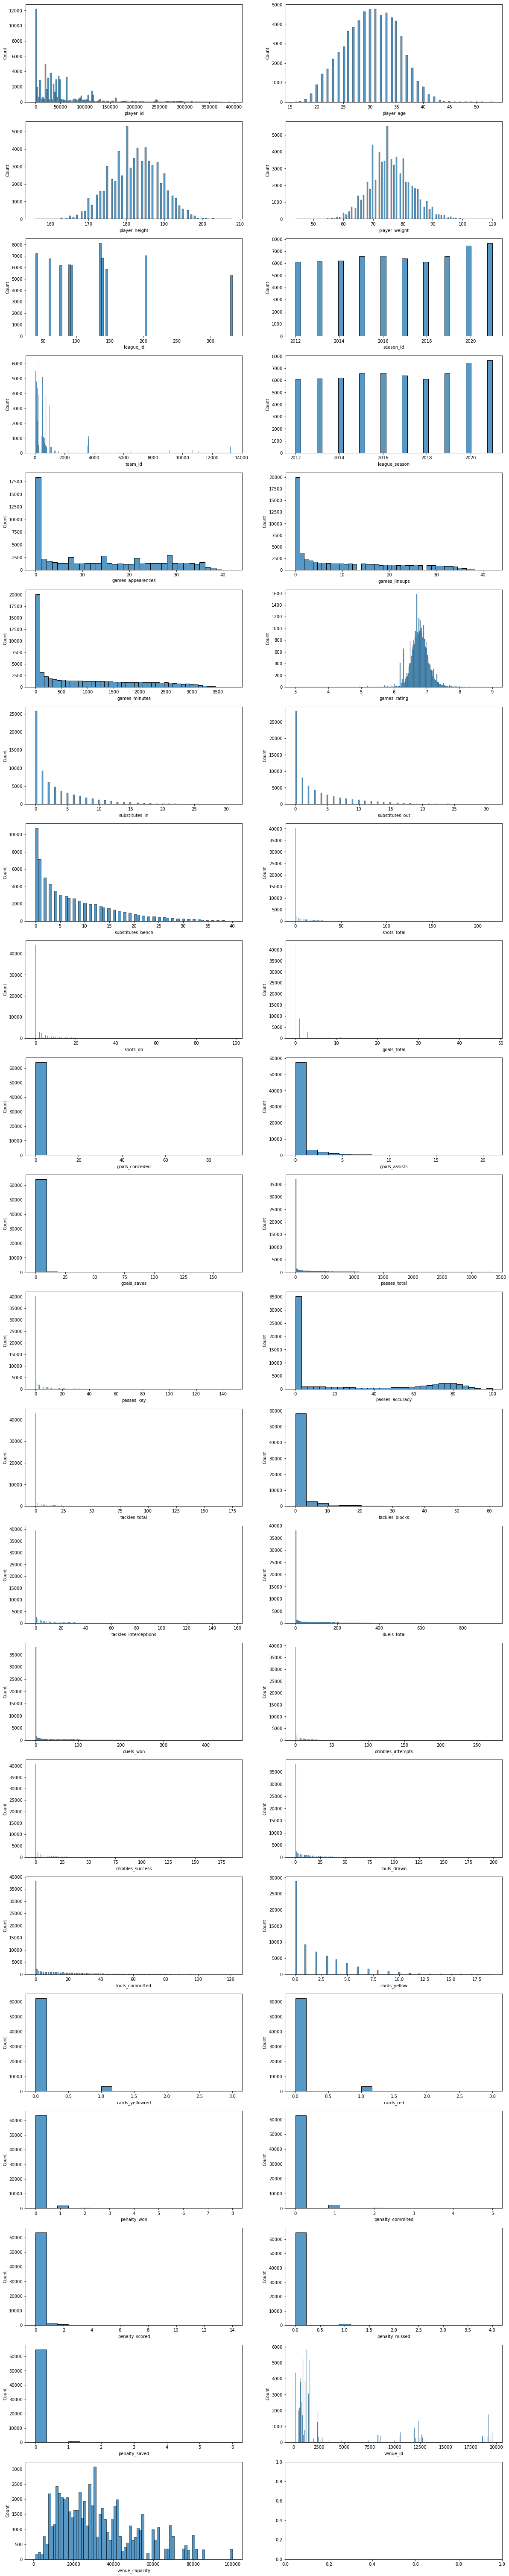

In [25]:
fDistNumCols(dfFootballCSV, dfFootballCSV.select_dtypes(include=np.number).columns, 2, 'x')

### Distributions of categorical columns

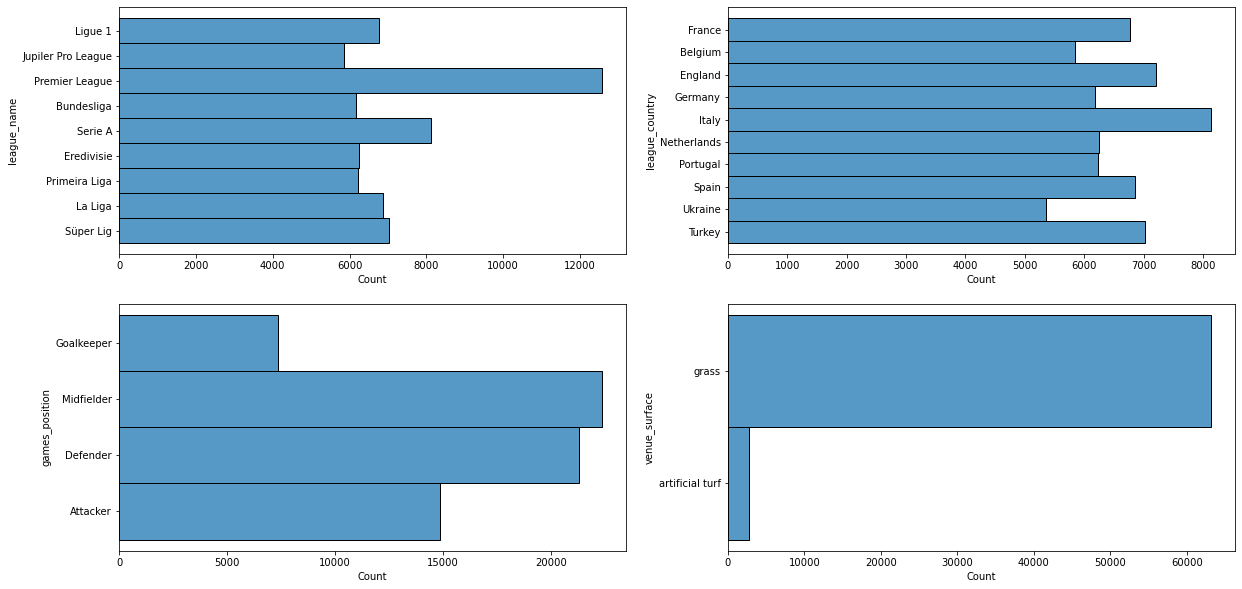

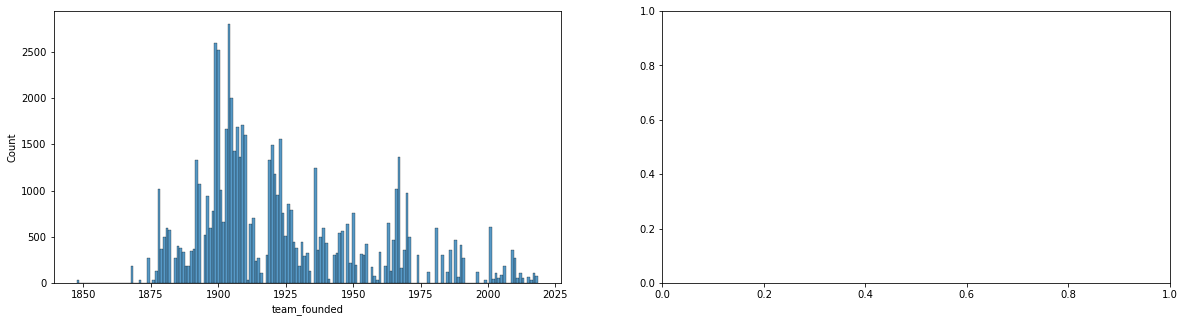

In [26]:
# Get all non-numeric columns
dfFootballCSV.select_dtypes(include=object).columns

# Select columns with low number of possible values
listDistNumCols = ['league_name','league_country','games_position','venue_surface']

fDistNumCols(dfFootballCSV, listDistNumCols, 2, 'y')
fDistNumCols(dfFootballCSV, ['team_founded'], 2, 'x')

Based on the information above, I will proceed with the data modification.

## Convert data types

Nothing needs to be converted, player_birth_date won't be used

In [27]:
# Convert player_birth_date
# dfFootballCSV['player_birth_date'] = pd.to_datetime(dfFootballCSV['player_birth_date'])

## Drop the fields not relevant to machine learning

- **player_name, player_firstname, player_lastname, player_photo, team_logo, league_flag, country_flag, league_logo, venue_image** - not relevant.
- **player_birth_date** - can be calculated based on player_age.
- **team_name, team_code** - represents the same data as *team_id*.
- **league_name, league_country, team_country, country_name, country_code** - represents the same data as *league_id*.
- **venue_name, venue_address** - represents the same data as *venue_id*.
- **league_season** - represents the same data as *league_id*.
- **games_rating** - a lot of missing values.
- **player_birth_country** - represent the same data as *player_nationality*.

In [28]:
dfFootball = dfFootballCSV.drop(['player_name','player_firstname','player_lastname','player_birth_date','player_photo',\
    'team_name','team_logo','league_name','league_country','league_logo','league_flag','team_code','team_country','venue_name',\
    'venue_address','venue_image','country_flag','country_name','country_code','league_season','games_rating',\
    'player_birth_country'], axis=1)

# Save for later
dfFootballBench = dfFootballCSV[['player_name','player_firstname','player_lastname','player_birth_date','player_photo',\
    'team_name','team_logo','league_name','league_country','league_logo','league_flag','team_code','team_country','venue_name',\
    'venue_address','venue_image','country_flag','country_name','country_code','league_season','games_rating',\
    'player_birth_country']]

## Conclusion

> - I dropped the columns that can't be used for the modeling: the majority of NA values that can't be populated, all NA values, the same value, not relevant, IDs, names, URLs.
> - Filled NA values.
> - Removed duplicated rows.
> - Removed rows with negative values.
> - Cleaned records with the escape characters.
> - Converted data types.
> - Checked distributions.

# Analytics

## Distributions of aggregated features

It allows us to check if there are any issues with the data. 

### Distribution of number of teams in leagues for all seasons
The number of teams in any league and season should be between 10 and 25. The majority of leagues have 18-20 teams. The result is expected.

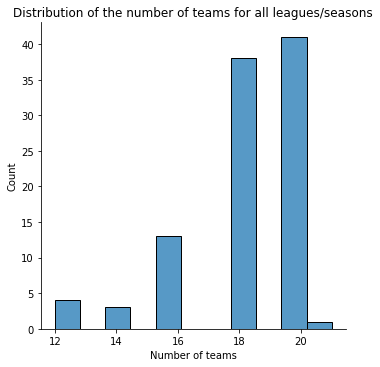

In [29]:
# Group by country and season
sns.displot(dfFootball.groupby(['league_id','season_id'])['team_id'].nunique())\
    .set(xlabel='Number of teams', title='Distribution of the number of teams for all leagues/seasons')

### Distribution of players in teams

The number of players in any team should be between 20 and 50. The majority of teams have 30-40 players. The result is expected.

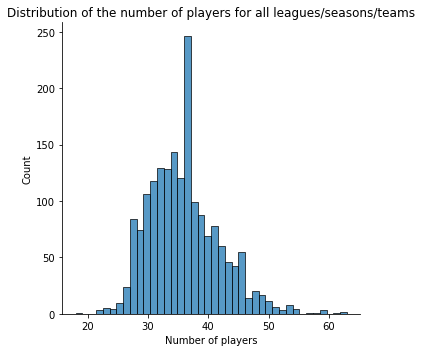

In [30]:
# Group by country, season and team
sns.displot(dfFootball.groupby(['league_id','season_id','team_id'])['player_id'].nunique())\
    .set(xlabel='Number of players', title='Distribution of the number of players for all leagues/seasons/teams')

plt.tight_layout()

## Relationship between features

### venue_city VS venue_id

I want to see if there is a 1-to-1 relation or there are a lot of different stadiums in the same city. Should we remove venue_id?

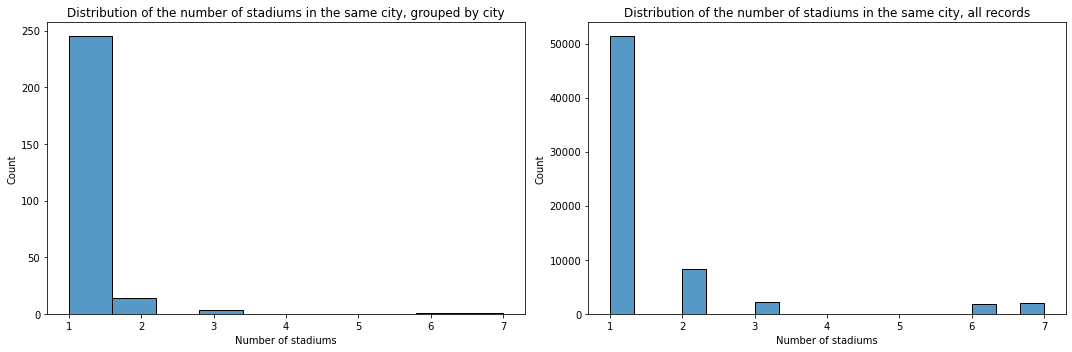

In [31]:
# Define subplots
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Get number of stadiums in the same city, plot histogram for unique number of cities
sns.histplot(dfFootball.groupby(['venue_city'])['venue_id'].nunique(), ax=ax[0])\
    .set(xlabel='Number of stadiums', title='Distribution of the number of stadiums in the same city, grouped by city')

# Get number of stadiums in the same city, plot histogram for all records
sns.histplot(dfFootball.merge(dfFootball.groupby(['venue_city'])[['venue_id']].nunique().reset_index(), on=['venue_city'],\
    suffixes=('', '_count'), copy=False)['venue_id_count'], ax=ax[1])\
    .set(xlabel='Number of stadiums', title='Distribution of the number of stadiums in the same city, all records')

plt.tight_layout()

We do not need to remove venue_id:
- The plot on the left shows there are several cities with more than one statium (2, 3, 6, 7).
- The plot on the right proves there are a lot of records with the cities having more than one stadium.

### venue_id VS team_id

Check if venue_id is unique for each team_id, if yes then remove that field.

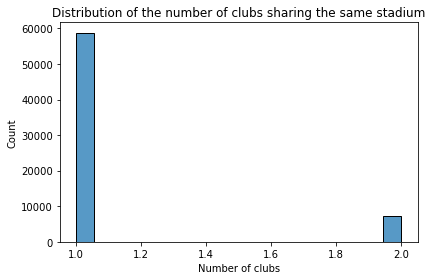

In [32]:
# Get number of clubs sharing the same stadium, plot histogram for all records
sns.histplot(dfFootball.merge(dfFootball.groupby(['venue_id'])[['team_id']].nunique().reset_index(), on=['venue_id'],\
    suffixes=('', '_count'), copy=False)['team_id_count'])\
    .set(xlabel='Number of clubs', title='Distribution of the number of clubs sharing the same stadium')

plt.tight_layout()

We can observe the same picture as the above. Hence we do not need to remove it.

## Relationship between features and target columns

The below helps to understand every single feature, and how it impacts the target variable. I will use scatterplot for that. One plot (on the left) will show all records and the other one (on the right) will show the mean of goals scored for each value.

In [33]:
# Used additionaly one by one, it takes a lot of time to run
# values = np.vstack([dfFootball["goals_total"], dfFootball["penalty_scored"]])
# kernel = stats.gaussian_kde(values)(values)
# sns.scatterplot(data=dfFootball, x='penalty_scored', y='goals_total', c=kernel, cmap="viridis")

### Plots

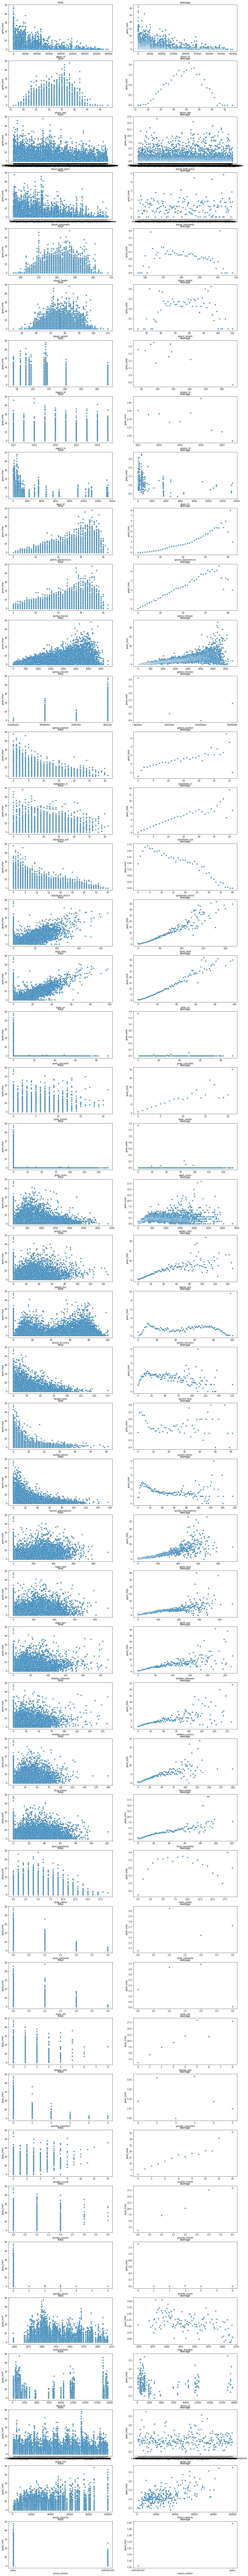

In [34]:
fScatter(dfFootball, dfFootball.drop('goals_total', axis=1).columns.to_list(), 'goals_total', 2, 20, 5)

### Analysis based on the plots

- **player_id** - interesting pattern, number of goals per season decreases for players with higher id. At first glance, you can think players are added based on theitr birth date. However, I quickly checked the data and noticed players are not added based on their age. It seems like they were added based on their performance or popularity or something like that. For example:
|player_id|birth_date|
|---|---|
|2|1987-09-18|
|3|1995-09-20|
|4|2001-02-27|
|368230|2006-05-05|
|373985|1993-04-03|
|396666|1974-04-27| 
- **player_age** - expected pattern, players score more goals when they are 25-35 years old and less when younger or older.
- **player_birth_place** - there is a slight dependency on how many players score based on their birth place. It probably depends on their country of origin.
- **player_birth_country** - the dependency is stronger here, it proves the statement above.
- **player_nationality** - the same as *player_birth_country*.
- **player_height** - on the one hand, players should be taller to score more goals. On the other hand, it is very similar to the height distribution (mean - 180cm, 25% - 178, 75% - 187). However, being taller is still very important to get high balls. There are 2 outliers: 163cm and 201cm. They are caused by the low number of records for the respective height.
- **player_weight** - the logic would be exactly the same as the above. To score more goals a player needs more weight but not too much. As we see on the average chart, in the range of 60-90. Again, the same explanation for the outliers.
- **league_id** - in some leagues players score more goals than in others.
- **strs** - no much difference between seasons.
- **team_id** - it is very important in which team you play, better team - more goals.
- **games_appearences** - positive linear correlation, more games players play - more chances to score a goal.
- **games_lineups** - positive linear correlation.
- **games_minutes** - positive linear correlation.
- **games_position** - very clear that the Attacker will have the most number of goals, then Midfielder, Defender, goalkeeper. - - **substitutes_in** - the opposite to *games_appearences*, the later a player is in the game the less chances to score a goal.
- **substitutes_out** - not so clear but similar to the above, the more a player plays the more they score.
- **substitutes_bench** - again very similar and have the same meaning.
- **shots_total** - probably the most important feature, clearly the more a player shoot the more they score. 
- **shots_on** - very similar to the above.
- **goals_conceded** - there is no correlation at all, it is a metric for keepers.
- **goals_assists** - not clear, probably depends on the position.
- **goals_saves** - metric for keepers.
- **passes_total** - negative correlation, attackers pass less.
- **passes_key** - negative correlation.
- **passes_accuracy** - more goals for low and high accuracy.
- **tackles_total** - more tackles - fewer goals. It distinguishes defenders from attackers.
- **tackles_blocks** - more tackles - fewer goals.
- **tackles_interceptions** - more tackles - fewer goals.
- **duels_total** - not so clear, possibly positive correlation.
- **duels_won** - positive correlation.
- **dribbles_attempts** - positive correlation.
- **dribbles_success** - positive correlation.
- **fouls_drawn** - positive correlation.
- **fouls_committed** - positive correlation.
- **cards_yellow** - goals are growing with the number of yellow cards, decreasing when players get more than 7 cards.
- **cards_yellowred** - negative correlation.
- **cards_red** - negative correlation.
- **penalty_won** - maybe negative correlation.
- **penalty_commited** - negative correlation.
- **penalty_scored** - weak positive correlation.
- **penalty_missed** - weak positive correlation.
- **penalty_saved** - metric for keepers.
- **team_founded** - there is a spike around 1900. Older clubs are more successful, hence their players score more goals.
- **venue_id** - very similar to *team_id*.
- **venue_city** - no correlation, a lot of distinct values.
- **venue_capacity** - positive correlation. More successful clubs have bigger stadiums.
- **venue_surface** - players scores more goals on the grass. It can be explained that more successful clubs play on grass, maybe not.

Ad-hoc code to check the above

In [35]:
# Check player id
dfTemp = dfFootballCSV[['player_id','player_birth_date']]

# Check player height
dfTemp = dfFootball.groupby('player_height')[['goals_total']].mean().reset_index()
dfFootball[dfFootball.player_height.isin(dfTemp[dfTemp.goals_total > 2.9]['player_height'])].shape

# Check weight
dfTemp = dfFootball.groupby('player_weight')[['goals_total']].mean().reset_index()
dfFootball[dfFootball.player_weight.isin(dfTemp[dfTemp.goals_total > 1.6]['player_weight'])].shape

(955, 47)

Drop columns based on the analysis above

- **player_id** - id field, a lot of distinct values.
- **player_birth_place** - many distinct values, plus there is 
player_birth_country which can be used better (fewer distinct values and more influence on players' skills).
- **season_id** - won't be able to use in a prediction, we can't go in the past. Also, it doesn't matter which year players scored a certain amount of goals.
- **goals_conceded, goals_saves, penalty_saved** - metric for keepers.
- **venue_city** - no correlation, a lot of distinct values.
- **penalty_scored** - no sense to predict based on that, as it is already goals scored.

In [36]:
dfFootball = dfFootball.drop(['player_id','player_birth_place','season_id','goals_conceded','goals_saves','penalty_saved',\
    'venue_city','penalty_scored'], axis=1)

Define features for ML and features that can be potentially used later

In [37]:
# Add non-numeric features
dfFootballMLBench = dfFootball.drop(dfFootball.select_dtypes(include=np.number).columns, axis=1)

dfFootballMLBench = pd.concat([dfFootballMLBench, dfFootballBench], axis=1)

# Add numeric features
dfFootballML = dfFootball[dfFootball.select_dtypes(include=np.number).columns]

## Conclusion

> - Distribution of the number of teams in a league and the number of players in a team follows the expected ones.
> - Was able to reduce the number of features.
> - Some features have strong correlations and will be used in the modeling. Some of them are not so clear and need additional insights.
> - More features can be dropped because of the multicollinearity.

# Statistical analysis

## Correlation

/var/folders/hn/r6dxb61155x4z2mwg4dbmqtc0000gq/T/ipykernel_12452/257347545.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(dfFootball.corr())
/var/folders/hn/r6dxb61155x4z2mwg4dbmqtc0000gq/T/ipykernel_12452/257347545.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dfFootball.corr(), annot=False, cmap=cmap, mask=mask)


<Axes: >

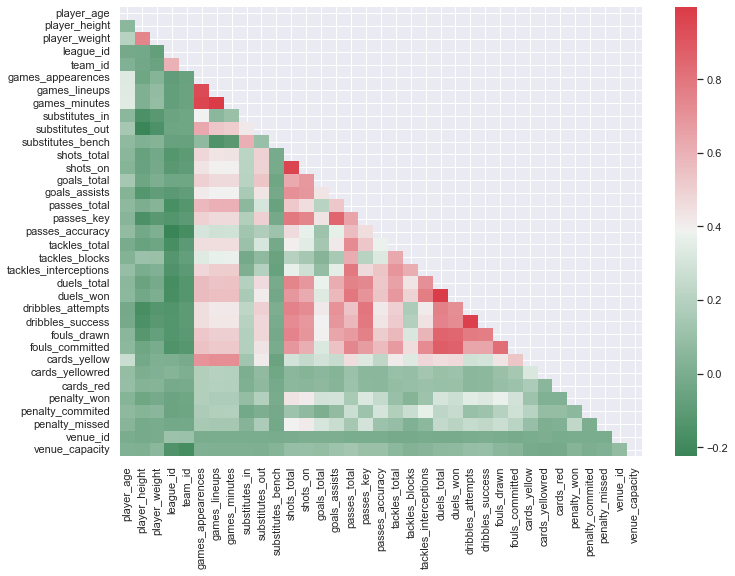

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Define color scheme
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# Hide upper triangle
mask = np.triu(dfFootball.corr())

# Display
sns.heatmap(dfFootball.corr(), annot=False, cmap=cmap, mask=mask)

In [39]:
# Define text
text_pos = 'The following columns are positively correlated with the goals_total column:\n'
text_neg = 'The following columns are negatively correlated with the goals_total column:\n'

# Loop through the all records just for the Mosquito number column
for i, k in dfFootball.corr()[['goals_total']].drop('goals_total').reset_index().iterrows():
    
    # Define strength
    if abs(k[1]) == 1.0:
        s = 'perfect'
    elif 0.8 <= abs(k[1]) < 1.0:
        s = 'very strong'
    elif 0.6 <= abs(k[1]) < 0.8:
        s = 'strong'
    elif 0.4 <= abs(k[1]) < 0.6:
        s = 'moderate'
    elif 0.2 <= abs(k[1]) < 0.4:
        s = 'weak'
    elif 0 < abs(k[1]) < 0.2:
        s = 'very weak'
    elif abs(k[1]) == 0:
        s = 'no'
    
    # Define if positive or negative
    if k[1] > 0:
        text_pos += f'\n\033[1m{k[0]}\033[0m - {s} correlation (correlation coeficient = \033[1m{round(k[1], 4)}\033[0m)'
    elif k[1] < 0:
        text_neg += f'\n\033[1m{k[0]}\033[0m - {s} correlation (correlation coeficient = \033[1m{round(k[1], 4)}\033[0m)'
    else:
        # no correlation
        pass

print(text_pos)
print('\n' + '-' * 100 +'\n')
print(text_neg)

The following columns are positively correlated with the goals_total column:

player_age - very weak correlation (correlation coeficient = 0.1445)
player_weight - very weak correlation (correlation coeficient = 0.0032)
games_appearences - moderate correlation (correlation coeficient = 0.4971)
games_lineups - moderate correlation (correlation coeficient = 0.4639)
games_minutes - moderate correlation (correlation coeficient = 0.4633)
substitutes_in - weak correlation (correlation coeficient = 0.205)
substitutes_out - moderate correlation (correlation coeficient = 0.5344)
shots_total - strong correlation (correlation coeficient = 0.6277)
shots_on - strong correlation (correlation coeficient = 0.6839)
goals_assists - moderate correlation (correlation coeficient = 0.4313)
passes_total - weak correlation (correlation coeficient = 0.2087)
passes_key - moderate correlation (correlation coeficient = 0.4381)
passes_accuracy - very weak correlation (correlation coeficient = 0.1181)
tackles_total 

/var/folders/hn/r6dxb61155x4z2mwg4dbmqtc0000gq/T/ipykernel_12452/3529849707.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  for i, k in dfFootball.corr()[['goals_total']].drop('goals_total').reset_index().iterrows():


Removed categorical features

In [40]:
# Separated non-numeric features
# dfFootballMLBench = dfFootball.drop(dfFootball.corr().columns, axis=1)

# Saved for the future transformation
dfFootballMLBench = pd.concat([dfFootballMLBench, dfFootball[['league_id','team_id','venue_id']]], axis=1)

# Removed from ML
dfFootballML = dfFootballML.drop(['league_id','team_id','venue_id'], axis=1)

### Statistical significance of the correlations
The next step is to check if the correlation above is statistically significant. In order to do that we will use the Person correlation. The function returns 2 values: correlation coefficient and p-value. The correlation coefficient has already been calculated in the step above. We need the p-value to perform the hypothesis testing.

$H_0$: There is no correlation between the independent and dependent variables.

$H_1$: There is a correlation between the independent and dependent variables.

We will reject the null hypothesis if the p-value is below the threshold of 0.05.

In [41]:
# Define dependent variable
y = dfFootball['goals_total']

# Define independent variables
X = dfFootball[dfFootball.corr().columns].drop('goals_total', axis=1)

# Get numeric columns
lst_num_col = X.columns.to_list()

for i in lst_num_col:
    
    X_col = X[i]
    
    # Perform Pearson test
    pvalue = stats.pearsonr(X_col,y)[1]
    
    # Reject the null hypothesis if p-value < 0.05
    if pvalue < 0.05:
        print(f'There is a statistically significant correlation between \033[1mgoals scored\033[0m and \033[1m{i}\033[0m (p-value = \033[1m{pvalue}\033[0m)')
    else:
        print(f'There is insufficient evidence if the correlation between \033[1mgoals scored\033[0m and \033[1m{i}\033[0m is statistically significant (p-value = \033[1m{pvalue}\033[0m)')
        

/var/folders/hn/r6dxb61155x4z2mwg4dbmqtc0000gq/T/ipykernel_12452/4278727570.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X = dfFootball[dfFootball.corr().columns].drop('goals_total', axis=1)


There is a statistically significant correlation between goals scored and player_age (p-value = 2.900976560101411e-304)
There is a statistically significant correlation between goals scored and player_height (p-value = 4.550288375245243e-31)
There is insufficient evidence if the correlation between goals scored and player_weight is statistically significant (p-value = 0.4071970323783534)
There is a statistically significant correlation between goals scored and league_id (p-value = 5.061520356264399e-27)
There is a statistically significant correlation between goals scored and team_id (p-value = 2.8352782046815826e-27)
There is a statistically significant correlation between goals scored and games_appearences (p-value = 0.0)
There is a statistically significant correlation between goals scored and games_lineups (p-value = 0.0)
There is a statistically significant correlation between goals scored and games_minutes (p-value = 0.0)
There is a statistically significant correlation between g

Remove statistically insignificant features

In [42]:
# Remove from ML
dfFootballML = dfFootballML.drop(['player_weight','penalty_commited'], axis=1)

# Saved for the future transformation
dfFootballMLBench = pd.concat([dfFootballMLBench, dfFootball[['player_weight']]], axis=1)

### Removed multicollinear features

We will use VIF for that.

In [43]:
# Define the features for the first run
X = dfFootballML.drop(['goals_total'],axis=1).select_dtypes(include=np.number)

# Define the features for the last run
X = dfFootballML.drop(['goals_total','games_lineups','games_appearences','duels_total','dribbles_attempts','shots_total'],\
    axis=1).select_dtypes(include=np.number)

# Add the interceptor
X_withconstant = sm.add_constant(X)

# Run VIF for each column
pd.Series([variance_inflation_factor(X_withconstant.values, i) 
    for i in range(X_withconstant.shape[1])], 
    index=X_withconstant.columns)[1:]

player_age               1.240836
player_height            1.181733
games_minutes            3.401213
substitutes_in           2.082662
substitutes_out          2.131715
substitutes_bench        1.811504
shots_on                 3.608501
goals_assists            3.806808
passes_total             5.409414
passes_key               6.852982
passes_accuracy          1.828837
tackles_total            3.116822
tackles_blocks           2.310278
tackles_interceptions    4.542009
duels_won                7.871096
dribbles_success         3.723381
fouls_drawn              5.618500
fouls_committed          6.145558
cards_yellow             2.626407
cards_yellowred          1.118753
cards_red                1.043829
penalty_won              1.291994
penalty_missed           1.232314
venue_capacity           1.056073
dtype: float64

Performed several runs and removed the following columns based on the VIF score:

1. **games_lineups** - the score was **inf**. Was correlated with *games_appearences*.
1. **games_appearences** - the score was **665.59**. Was correlated with *games_minutes*.
1. **duels_total** - the score was **81.69**. Was correlated with *duels_won*.
1. **dribbles_attempts** - the score was **28.00**. Was correlated with *dribbles_success*.
1. **shots_total** - the score was **18.56**. Was correlated with *shots_on*.

In [44]:
dfFootballML = dfFootballML.drop(['games_lineups','games_appearences','duels_total','dribbles_attempts','shots_total'], axis=1)

## Conclusion

> - Almost all numeric fields have a statistically significant correlation with the target variable.
> - I was to define the features with weak correlation against the target and remove them.
> - I removed features with a high correlation between each other to avoid multicollinearity.
> - I saved the categorical features for future transformation.
> - In the majority of the cases, players scored 0 goals. I need to take this into account when analyzing the results of the modeling.

# Save the results

In [45]:
dfFootballML.to_csv('data/football_ml.csv', index=False)
dfFootballMLBench.to_csv('data/football_ml_bench.csv', index=False)